# Module 3: MLOps and Real World Scenarios: Get Hands-On

## Part 3 - MLOps Deployment with NLP
## News Article Summarization and Keyword Extraction via NLP

This notebook demonstrates how to create and server an NLP pipeline that summarizes and extract keywords from a news article URL. The state-of-the-art transformer models such as BERT will be used to perform the NLP tasks.

**Tutorial Steps:**
- [**Install MLRun and Dependencies**](#install-mlrun-dependencies)
- [**Setup the Project**](#mlrun-project-setup)
- [**Create the MLRun Function**](#code-to-function-nlp-transformations)
- [**Define Real-Time Serving Graph**](#define-real-time-serving-graph)

**NLP Transformations:**
- Retrieve news article text and metadata from URL using newspaper3k.
- Summarize article text via Huggingface pipeline using DistilBart model.
- Extract article keywords via KeyBERT using BERT-embeddings and cosine similarity.
- Remove the original article text from the response (optional).

<a id="install-mlrun-dependencies"></a>
## Install MLRun and Dependencies

This tutorial expects the MLRun backend service to be running on a Kubernetes Cluster.

**Note:** Throughout this tutorial, the GKE Cluster which was set up in Part 0 will be used to run the MLRun backend service.

In [1]:
# Ensure that Python 3 (preferred version: 3.9.x) and pip 22.x.y are installed on the machine.

# Check the Python version.
!python --version

# Check the pip version.
!python -m pip --version

Python 3.9.13
pip 22.3.1 from /opt/conda/lib/python3.9/site-packages/pip (python 3.9)


In [ ]:
# Install MLRun, Transformers, Newspaper3k, KeyBERT, and other dependencies.

# Note: This cell needs to be run only once. The notebook needs to be restarted after a successful installation.

!pip install mlrun transformers==4.11.3 newspaper3k==0.2.8 keybert~=0.7.0

**Restart the notebook kernel after the pip installation.**

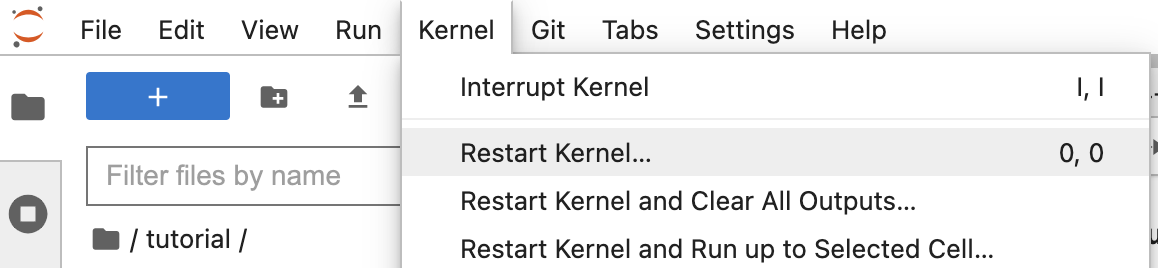

<a id="mlrun-project-setup"></a>
## Setup the Project

Create an MLRun project using `mlrun.get_or_create_project()` (make sure to load the desired project in case one already exists).

In [3]:
# Import the required Python packages.
import mlrun
import os

# Set MLRun Project's name.
project_name = "nlp-demo"

# Create the MLRun Project.
project = mlrun.get_or_create_project(name=project_name, context="./", user_project=True)

> 2023-08-04 20:07:21,786 [info] Project loaded successfully: {'project_name': 'nlp-demo'}


<a id="code-to-function-nlp-transformations"></a>
## Create the MLRun Function

MLRun's `mlrun.code_to_function()` can be used to create an MLRun Function from the `nlp_transformations.py` code.

In [5]:
# Initialize a Serverless Function for NLP Transformations using the `nlp_transformations.py` file/
nlp_func = mlrun.code_to_function(name="news-article-nlp", filename="nlp_transformations.py",
                            kind="serving", image='mlrun/ml-models')

# Set the function specifications.
nlp_func.spec.min_replicas = 1
nlp_func.spec.max_replicas = 1
nlp_func.spec.build.commands = [
    "python -m pip install transformers==4.11.3 newspaper3k==0.2.8 keybert~=0.7.0",
    "python -c 'from transformers import pipeline; pipeline(\"summarization\")'",
    "python -c 'from keybert import KeyBERT; KeyBERT()'"
]

# Set the required Environment Variables.
nlp_func.set_env("SENTENCE_TRANSFORMERS_HOME","/tmp")
nlp_func.set_env("TRANSFORMERS_CACHE","/tmp")

> 2023-08-04 20:07:57,060 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/home/jovyan'}


<a id="define-real-time-serving-graph"></a>
## Define Real-Time Serving Graph
Here the functions and classes required for the pipeline will be orchestrated. The source code for these functions is located in `nlp_transformations.py`.

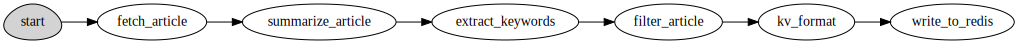

In [6]:
# Set the Redis URL.
redis_url = "redis://:gwEswJlH3f@redis-master.mlrun.svc.cluster.local:6379"

# Set the serving topology for the Serving Serverless Function.
graph = nlp_func.set_topology("flow", engine="async")

graph.to(name="fetch_article", handler="fetch_article")\
     .to(name="summarize_article", class_name="SummarizeArticle")\
     .to(name="extract_keywords", class_name="ExtractKeywords")\
     .to(name="filter_article", handler="filter_article")\
     .to(name="kv_format", handler="kv_format", full_event=True)

graph.add_step(name='write_to_redis',class_name="storey.NoSqlTarget", table=redis_url, after='kv_format').respond()

graph.plot(rankdir='LR')

### Test the Pipeline Locally (using simulator)

In [7]:
# Import the step functions for simulation.
from nlp_transformations import *

# Create a mock server (simulator).
server = nlp_func.to_mock_server()

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [8]:
# Test the pipeline.
server.test("/", body={"url" : "https://edition.cnn.com/2022/10/22/china/china-party-congress-overseas-students-protest-intl-hnk/index.html"})

{'url': 'https://edition.cnn.com/2022/10/22/china/china-party-congress-overseas-students-protest-intl-hnk/index.html',
 'title': 'Anti-Xi protest spreads in China and worldwide as Chinese leader begins third term',
 'authors': '["Cnn Staff"]',
 'publish_date': '2022-10-22 00:00:00',
 'summarized_text': ' Anti-Xi slogans have popped up in a growing number of Chinese cities and hundreds of universities worldwide . CNN spoke with two Chinese citizens who scribbled slogans in bathroom stalls and half a dozen overseas Chinese students who put up anti-Xi posters on their campuses . China’s party has ramped up surveillance and control of the Chinese diaspora, intimidating and harassing those who dare to speak out .',
 'keywords': '["jolie", "tiananmen", "scribbled", "risks", "a4"]'}

### Containerize and Deploy Pipeline on K8s
The application is containerized and deployed to Kubernetes Cluster.

In [9]:
nlp_func.spec.readinessTimeoutSeconds = 60 * 20  # 20 minutes.
nlp_func.deploy()

> 2023-08-04 20:09:29,441 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-08-04 20:09:29,446 [info] Starting remote function deploy
2023-08-04 20:09:29  (info) Deploying function
2023-08-04 20:09:29  (info) Building
2023-08-04 20:09:29  (info) Staging files and preparing base images
2023-08-04 20:09:30  (info) Building processor image
2023-08-04 20:09:34  (info) Build complete
2023-08-04 20:10:21  (info) Function deploy complete
> 2023-08-04 20:10:30,451 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-nlp-demo-jovyan-news-article-nlp.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['34.135.160.246:31534']}


'http://34.135.160.246:31534'

### Test Pipeline with URLs From Various News Sources 
The pipeline can be tested with various news sources. This pipeline should work with any source compatible with the `newspaper3k` Python library.

In [ ]:
fn.invoke(
    path="/",
    body={"url" : "https://edition.cnn.com/2022/10/22/china/china-party-congress-overseas-students-protest-intl-hnk/index.html"}
)

In [ ]:
fn.invoke(
    path="/",
    body={"url" : "https://edition.cnn.com/2022/10/23/entertainment/matthew-perry-jennifer-aniston-alcohol/index.html"}
)

In [ ]:
fn.invoke(
    path="/",
    body={"url" : "https://www.npr.org/2022/10/24/1130915534/the-houston-astros-and-philadelphia-phillies-will-face-each-other-in-the-world-s"}
)

In [ ]:
fn.invoke(
    path="/",
    body={"url" : "https://abcnews.go.com/Politics/jan-committee-trumps-testimony-circus-cheney/story?id=91963586",
          "filter_article" : False}
)